In [35]:
import os
import glob
import PIL
import cv2
import random
from PIL import Image
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow
import tensorflow as tf
from tensorflow.keras import layers
import keras 
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from IPython.display import display
from PIL import Image

%matplotlib inline

In [2]:
# Download DataSet From 

# https://www.kaggle.com/datasets/sakshaymahna/cityscapes-depth-and-segmentation

In [3]:
# Getting per image .npy file from the location and converting into img Matrix

curr_path = os.getcwd() 

def get_data_from_file(directory, d_type='float'):
    dataset = []
    for img in directory:
        img_matrix = np.load(img)
        dataset.append(img_matrix.astype(d_type))
    dataset = np.stack(dataset)
    return dataset


train_image = glob.glob(curr_path + '\\data\\train\\image\\*.npy')
train_label = glob.glob(curr_path + '\\data\\train\\label\\*.npy')

val_image = glob.glob(curr_path + '\\data\\val\\image\\*.npy')
val_label = glob.glob(curr_path + '\\data\\val\\label\\*.npy')

train_image_dataset = get_data_from_file(train_image)
train_label_dataset = get_data_from_file(train_label, 'int')
val_image_dataset = get_data_from_file(val_image)
val_label_dataset = get_data_from_file(val_label, 'int')

print(f'train_image_dataset shape: {train_image_dataset.shape}')
print(f'train_label_dataset shape: {train_label_dataset.shape}')
print(f'val_image_dataset shape: {val_image_dataset.shape}')
print(f'val_label_dataset shape: {val_label_dataset.shape}')

train_image_dataset shape: (2975, 128, 256, 3)
train_label_dataset shape: (2975, 128, 256)
val_image_dataset shape: (500, 128, 256, 3)
val_label_dataset shape: (500, 128, 256)


In [4]:
# Defining Dataset size to train 

train_img_size = 750
test_img_size = 200

train_image_dataset = train_image_dataset[:train_img_size]
train_label_dataset = train_label_dataset[:train_img_size]

val_image_dataset = val_image_dataset[:test_img_size]
val_label_dataset = val_label_dataset[:test_img_size]

In [5]:
# Resize the image and mask and also expand the dimension of the Mask Image

img_size = 224

train_image_dataset = np.array(tf.image.resize(train_image_dataset, (img_size,img_size), method=tf.image.ResizeMethod.BILINEAR))

train_label_dataset = np.expand_dims(train_label_dataset, axis=3)
train_label_dataset = np.array(tf.image.resize(train_label_dataset, (img_size,img_size), method=tf.image.ResizeMethod.BILINEAR))

val_image_dataset = np.array(tf.image.resize(val_image_dataset, (img_size,img_size), method=tf.image.ResizeMethod.BILINEAR))

val_label_dataset = np.expand_dims(val_label_dataset, axis=3)
val_label_dataset = np.array(tf.image.resize(val_label_dataset, (img_size,img_size), method=tf.image.ResizeMethod.BILINEAR))

print(f'train_image_dataset shape: {train_image_dataset.shape}')
print(f'train_label_dataset shape: {train_label_dataset.shape}')
print(f'val_image_dataset shape: {val_image_dataset.shape}')
print(f'val_label_dataset shape: {val_label_dataset.shape}')

train_image_dataset shape: (750, 224, 224, 3)
train_label_dataset shape: (750, 224, 224, 1)
val_image_dataset shape: (200, 224, 224, 3)
val_label_dataset shape: (200, 224, 224, 1)


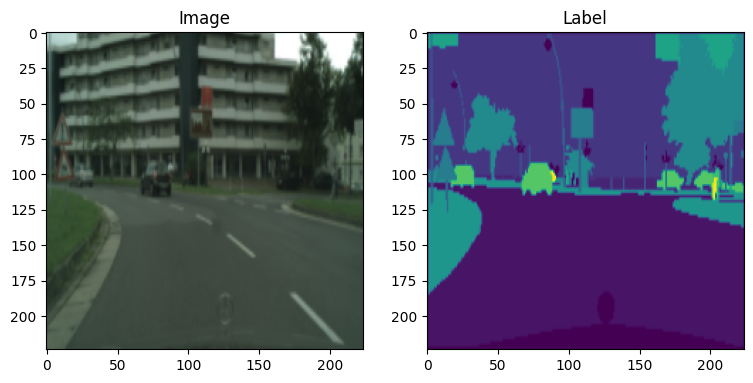

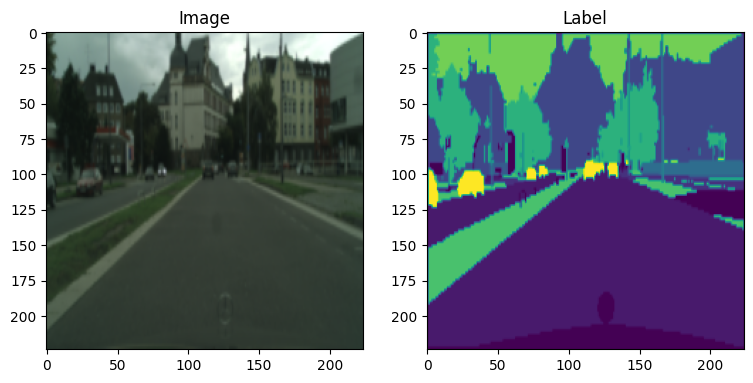

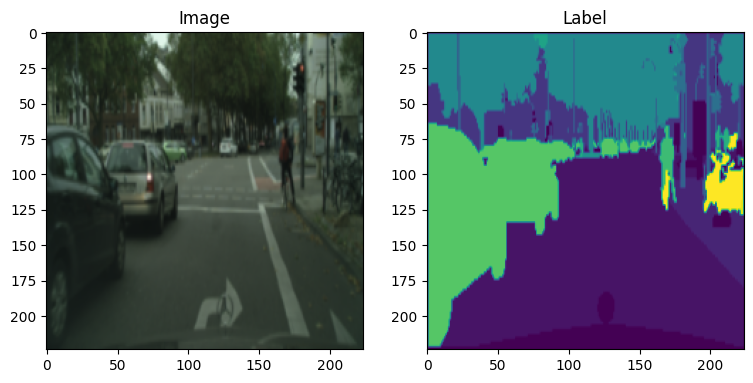

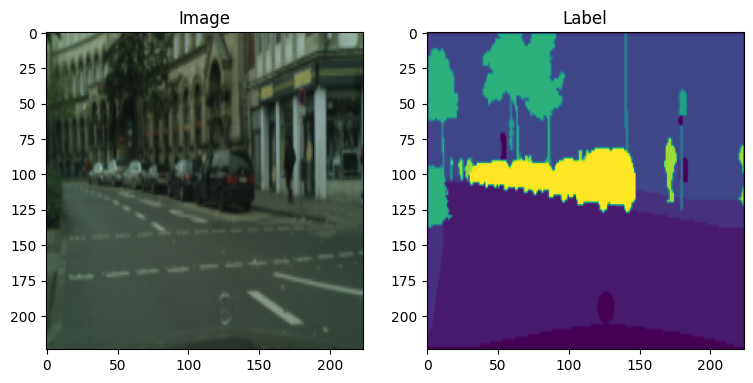

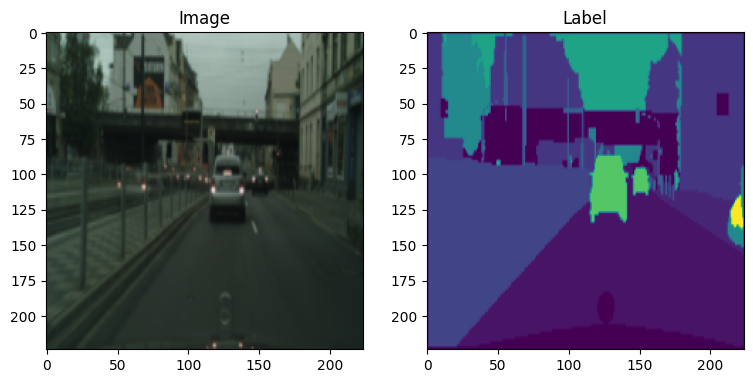

In [6]:
# Visulization of Some of the Example of the Image with there Mask

for i in range(5):
    plt.figure(figsize=(9,7))
    plt.subplot(121)
    plt.title('Image')
    plt.imshow(train_image_dataset[i], cmap='gray')
    plt.subplot(122)
    plt.title('Label')
    plt.imshow(train_label_dataset[i])

In [7]:
# PRINT DIFFERENT CLASSES AND MASK_CLASSES

train_label_classes = np.unique(train_label_dataset)
mask_classes = np.arange(0,19)
n_classes = len(mask_classes)
print(f'No of Classes are : {n_classes}')

No of Classes are : 19


In [8]:
# Making function that do one hot Encoding of the Mask Images

def one_hot_encode(label):
    label_values = [[x] for x in range(0,19)]
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [9]:
# OnehotEncoding Mask images and converting into tensor 

train_label_oneHot = tensorflow.convert_to_tensor(one_hot_encode(train_label_dataset))
val_label_oneHot = tensorflow.convert_to_tensor(one_hot_encode(val_label_dataset))
train_label_oneHot

<tf.Tensor: shape=(750, 224, 224, 19), dtype=bool, numpy=
array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, Fa

In [10]:
# Length of the Training and Testing Datasets

print(f'Len of X_train :{train_image_dataset.shape}')
print(f'Len of X_test :{train_label_oneHot.shape}')
print(f'Len of y_train :{val_image_dataset.shape}')
print(f'Len of y_test :{val_label_oneHot.shape}')

Len of X_train :(750, 224, 224, 3)
Len of X_test :(750, 224, 224, 19)
Len of y_train :(200, 224, 224, 3)
Len of y_test :(200, 224, 224, 19)


In [11]:
# Image Shape

img_shape = list(train_image_dataset[0].shape)
img_shape

[224, 224, 3]

In [12]:
# Making the Tensor Slices of Training and Testing data of fixed batch size

batch_size = 5

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_dataset, train_label_oneHot)).batch(batch_size).shuffle(1000)
test_dataset = tf.data.Dataset.from_tensor_slices((val_image_dataset, val_label_oneHot)).batch(batch_size)
print(train_dataset) 
print(test_dataset)

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 19), dtype=tf.bool, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 19), dtype=tf.bool, name=None))>


In [86]:
# Making U-net Model

OUTPUT_CHANNELS = n_classes
input_img_shape = list(train_image_dataset[0].shape)

base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size,img_size,3), include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [87]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [88]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [89]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [90]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3))

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [91]:
# Inilizaion of Model Compile 

OUTPUT_CLASSES = n_classes

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
# Visulizing the model Architecture

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_13 (Functional)           [(None, 112, 112, 96 1841984     input_22[0][0]                   
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 14, 14, 512)  1476608     model_13[0][4]                   
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 14, 14, 1088) 0           sequential_24[0][0]              
                                                                 model_13[0][3]            

In [93]:
SAVE_PERIOD = 25

checkpoint_path = curr_path + r'\callbacks\UNET-model-{epoch:02d}-{val_loss:.2f}.hdf5' 

# Create a callback that saves the model's weights every 50 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5),
    verbose=1, 
    save_weights_only=True,
    monitor='accuracy',
    period =SAVE_PERIOD,
    save_best_only=True)

In [94]:
# Training the Model

epochs = 200
history = model.fit(train_dataset,
                epochs = epochs,
                steps_per_epoch=len(train_image_dataset) // batch_size,
                verbose=1, 
                callbacks=cp_callback,
                validation_data=test_dataset)

Epoch 1/200
150/150 [==============================] - 22s 77ms/step - loss: 0.8256 - accuracy: 0.6714 - val_loss: 0.6937 - val_accuracy: 0.7002
Epoch 2/200
150/150 [==============================] - 11s 70ms/step - loss: 0.6368 - accuracy: 0.7353 - val_loss: 0.7936 - val_accuracy: 0.7114
Epoch 3/200
150/150 [==============================] - 11s 70ms/step - loss: 0.6638 - accuracy: 0.7196 - val_loss: 0.7197 - val_accuracy: 0.6256
Epoch 4/200
150/150 [==============================] - 11s 70ms/step - loss: 0.6847 - accuracy: 0.7046 - val_loss: 0.8416 - val_accuracy: 0.5743
Epoch 5/200
150/150 [==============================] - 11s 70ms/step - loss: 0.6970 - accuracy: 0.6906 - val_loss: 0.8135 - val_accuracy: 0.5989
Epoch 6/200
150/150 [==============================] - 11s 70ms/step - loss: 0.7004 - accuracy: 0.6794 - val_loss: 0.7478 - val_accuracy: 0.6286
Epoch 7/200
150/150 [==============================] - 11s 70ms/step - loss: 0.7087 - accuracy: 0.6726 - val_loss: 0.8144 - val_ac

Epoch 56/200
150/150 [==============================] - 11s 71ms/step - loss: 0.8299 - accuracy: 0.6493 - val_loss: 0.8397 - val_accuracy: 0.6333
Epoch 57/200
150/150 [==============================] - 11s 71ms/step - loss: 0.8376 - accuracy: 0.6520 - val_loss: 0.8393 - val_accuracy: 0.6494
Epoch 58/200
150/150 [==============================] - 11s 71ms/step - loss: 0.8441 - accuracy: 0.6536 - val_loss: 0.8664 - val_accuracy: 0.6079
Epoch 59/200
150/150 [==============================] - 11s 71ms/step - loss: 0.8548 - accuracy: 0.6474 - val_loss: 0.8676 - val_accuracy: 0.6267
Epoch 60/200
150/150 [==============================] - 11s 71ms/step - loss: 0.8662 - accuracy: 0.6486 - val_loss: 0.8735 - val_accuracy: 0.6300
Epoch 61/200
150/150 [==============================] - 11s 71ms/step - loss: 0.8693 - accuracy: 0.6528 - val_loss: 0.8711 - val_accuracy: 0.6212
Epoch 62/200
150/150 [==============================] - 11s 71ms/step - loss: 0.8827 - accuracy: 0.6484 - val_loss: 0.8809 -

150/150 [==============================] - 11s 72ms/step - loss: 2.0839 - accuracy: 0.6288 - val_loss: 2.1233 - val_accuracy: 0.6144
Epoch 167/200
150/150 [==============================] - 11s 71ms/step - loss: 2.1190 - accuracy: 0.6204 - val_loss: 2.1498 - val_accuracy: 0.5606
Epoch 168/200
150/150 [==============================] - 11s 71ms/step - loss: 2.0998 - accuracy: 0.6235 - val_loss: 2.0902 - val_accuracy: 0.6061
Epoch 169/200
150/150 [==============================] - 11s 71ms/step - loss: 2.1124 - accuracy: 0.6233 - val_loss: 2.0946 - val_accuracy: 0.6037
Epoch 170/200
150/150 [==============================] - 11s 71ms/step - loss: 2.1424 - accuracy: 0.6216 - val_loss: 2.1964 - val_accuracy: 0.5759
Epoch 171/200
150/150 [==============================] - 11s 71ms/step - loss: 2.1394 - accuracy: 0.6220 - val_loss: 2.1040 - val_accuracy: 0.6232
Epoch 172/200
150/150 [==============================] - 11s 71ms/step - loss: 2.1662 - accuracy: 0.6224 - val_loss: 2.1705 - val_ac

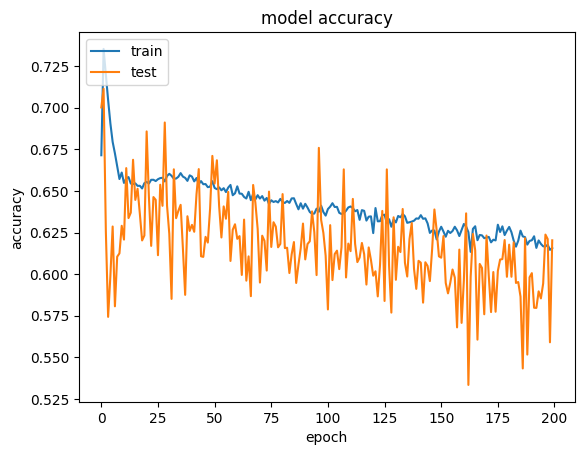

In [95]:
# summarize history for accuracy

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

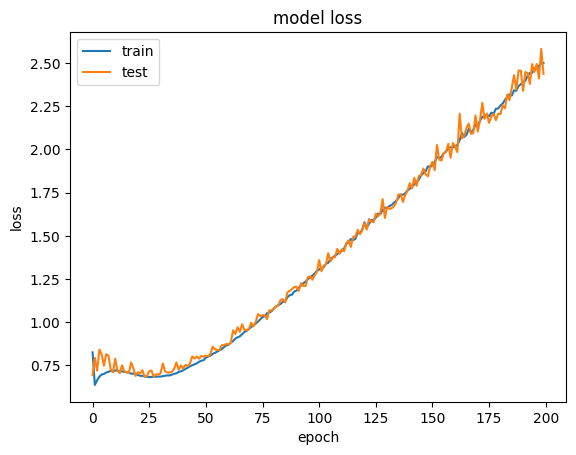

In [96]:
# summarize history for loss

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
# To save whole Model

model.save("unet_segmentation.h5")
print("Saved model to disk")

C:\Users\ADMIN\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk


In [102]:
# Loading the Saved Model back

model = tensorflow.keras.models.load_model('unet_segmentation.h5')

In [116]:
# Predicting Validation dataset

predicted_img = model.predict(val_image_dataset[:10])
predicted_img.shape

(10, 224, 224, 19)

In [117]:
# Argmax the Predicted Image

predicted_mask=np.argmax(predicted_img, axis=3)
predicted_mask.shape

(10, 224, 224)

In [122]:
# Argmax the real mask Image

real_mask=np.argmax(train_label_oneHot[:10], axis=3)
real_mask.shape

(10, 224, 224)

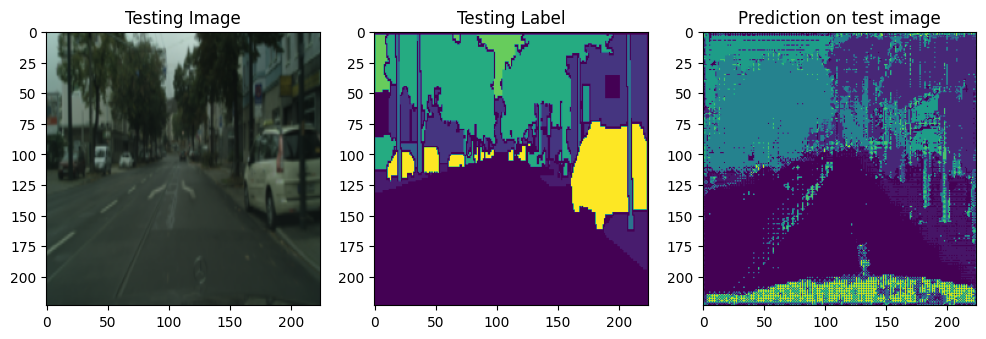

In [128]:
# Visulization of the Model Predicted
rand =  random.randint(0, real_mask.shape[0])
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(train_image_dataset[rand])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(real_mask[rand])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_mask[rand])
plt.show()